# Geometric Multigrid for 2D Poisson
 
Poisson Equation:

\begin{align*}
\Delta u &= f, & \Omega \\
u &= 0, & \partial \Omega
\end{align*}

Discretizing with finite differences on a regular 2D mesh yields a 5-point 4, -1 stencil. 

Discretizing with finite elements on a regular 2D mesh with bilinear quadrilateral elements yiels a 9-point 8, -1 stencil.

In [149]:
# Get some code for generating test problems from PyAMG
# PyAMG: https://github.com/pyamg/pyamg
!wget -Nq https://raw.githubusercontent.com/pyamg/pyamg/master/pyamg/gallery/diffusion.py
!wget -Nq https://raw.githubusercontent.com/pyamg/pyamg/master/pyamg/gallery/stencil.py

In [9]:
# Import some python libraries we need
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import stencil
import diffusion

# 2D Model problem
def ModelProblem2D(n):
    sten = diffusion.diffusion_stencil_2d(epsilon=1.0, theta=0.0, type='FE')
    A = stencil.stencil_grid(sten, (n-1,n-1), format='csr')
    return A.toarray()*n*n

# Define Gauss-Seidel
def GaussSeidel(A,u,f):
    for i in range(len(u)):
        u[i] = (1.0/A[i,i])*(f[i] - np.dot(A[i,:],u) + A[i,i]*u[i])

# Linear interpolation in 2D
def LinearInterpolation2D(n):
    N = (n-1)*(n-1) # fine-grid matrix size
    n_c = int(n/2) # coarse-grid number of points in 1D
    N_c = (n_c-1)*(n_c-1) # coarse-grid matrix size
    P = np.zeros((N,N_c))
    for row in range(N):
        x = row % (n-1)
        y = int(row / (n-1))
        # Four point interpolation
        if x % 2 == 0 and y % 2 == 0:
            x_c = int(x/2 - 1)
            y_c = int(y/2 - 1)
            if x_c >= 0 and y_c >= 0:
                P[row,x_c + (n_c-1)*y_c] = 0.25
            if (x_c+1) < n_c-1 and y_c >= 0:
                P[row,(x_c+1) + (n_c-1)*y_c] = 0.25
            if x_c >= 0 and (y_c+1) < n_c-1:
                P[row,x_c + (n_c-1)*(y_c+1)] = 0.25
            if (x_c+1) < n_c-1 and (y_c+1) < n_c-1:
                P[row,(x_c+1) + (n_c-1)*(y_c+1)] = 0.25
        # Two-point x interpolation
        elif x % 2 == 0:
            x_c = int(x/2 - 1)
            y_c = int(y/2)
            if x_c >= 0:
                P[row,x_c + (n_c-1)*y_c] = 0.5
            if (x_c+1) < n_c-1:
                P[row,(x_c+1) + (n_c-1)*y_c] = 0.5
        # Two-point y interpolation
        elif y % 2 == 0:
            x_c = int(x/2)
            y_c = int(y/2 - 1)
            if y_c >= 0:
                P[row,x_c + (n_c-1)*y_c] = 0.5
            if (y_c+1) < n_c-1:
                P[row,x_c + (n_c-1)*(y_c+1)] = 0.5
        # Injected C point
        else:
            x_c = int(x/2)
            y_c = int(y/2)
            P[row,x_c + (n_c-1)*y_c] = 1.0
    return P

# Restriction by full-weighting
def RestrictionFullWeighting2D(n):
    P = LinearInterpolation2D(n)
    R = 0.25*P.transpose()
    return R

In [8]:
# Compare A_c and RAP with FD and FE discrestization
n = 16 # total points in 1D (0,n are the boundary points)
N = (n-1)*(n-1)
A = ModelProblem2D(n)
P = LinearInterpolation2D(n)
R = RestrictionFullWeighting2D(n)
A_c = ModelProblem2D(int(n/2))
print(A_c)
print(np.dot(R, np.dot(A,P)))

[[170.66666667 -21.33333333   0.         ...   0.           0.
    0.        ]
 [-21.33333333 170.66666667 -21.33333333 ...   0.           0.
    0.        ]
 [  0.         -21.33333333 170.66666667 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 170.66666667 -21.33333333
    0.        ]
 [  0.           0.           0.         ... -21.33333333 170.66666667
  -21.33333333]
 [  0.           0.           0.         ...   0.         -21.33333333
  170.66666667]]
[[170.66666667 -21.33333333   0.         ...   0.           0.
    0.        ]
 [-21.33333333 170.66666667 -21.33333333 ...   0.           0.
    0.        ]
 [  0.         -21.33333333 170.66666667 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 170.66666667 -21.33333333
    0.        ]
 [  0.           0.           0.         ... -21.33333333 170.66666667
  -21.33333333]
 [  0.           0.           0.         ...   0.         -21.33333333
  170.666

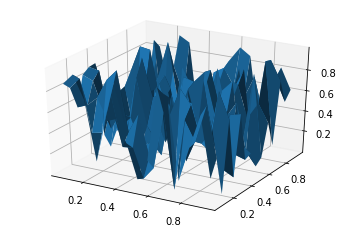

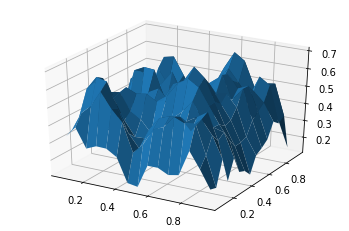

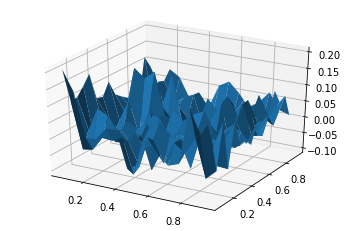

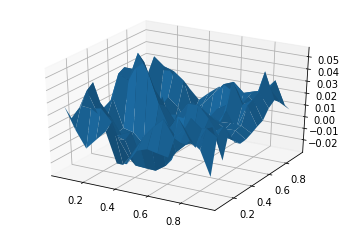

In [16]:
# Fine grid problem
n = 16 # total points in 1D (0,n are the boundary points)
N = (n-1)*(n-1)
A = ModelProblem2D(n)

# RHS, soln, initial
u_final = np.zeros(N)
f = np.dot(A,u_final)
u = np.random.rand(N)
u_init = u.copy()

# Two-grid cycle
GaussSeidel(A,u,f) # fine-grid relax
u_post_relax = u.copy()
r = f - np.dot(A,u) # residual calculation
r_c = np.dot(R,r) # residual restriction
e_c = np.linalg.solve(A_c, r_c) # coarse-grid solve
e = np.dot(P,e_c) # interpolate correction
u = u + e # add correction
u_corrected = u.copy()
GaussSeidel(A,u,f) # fine-grid relax

# Setup meshgrid for plotting 2D solution
X, Y = np.meshgrid(np.arange(1.0/n,1.0,1.0/n),np.arange(1.0/n,1.0,1.0/n))

# Initial
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, np.reshape(u_init,(n-1,n-1)))

# After relaxation
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, np.reshape(u_post_relax,(n-1,n-1)))

# After coarse-grid correction
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, np.reshape(u_corrected,(n-1,n-1)))

# After post-relax
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, np.reshape(u,(n-1,n-1)))


16129
0.10366860194433197


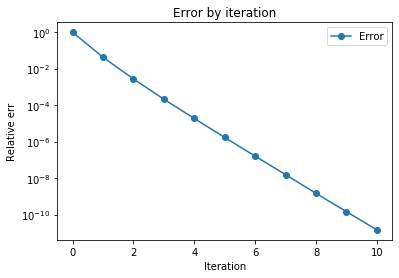

In [21]:
# Fine grid problem
n = 128 # total points in 1D (0,n are the boundary points), choose a power of 2.
N = (n-1)*(n-1)
A = ModelProblem2D(n)

# RHS, soln, initial
u_final = np.zeros(N)
f = np.dot(A,u_final)
u = np.random.rand(N)
u_init = u.copy()

# Setup the hierarchy
n_fine = n
num_levels = 1
A_array = [A]
u_array = [u]
f_array = [f]
P_array = []
R_array = []
while n_fine > 4:
    P_array.append( LinearInterpolation2D(n_fine) )
    R_array.append( RestrictionFullWeighting2D(n_fine) )
    n_fine = int(n_fine/2)
    A_array.append( ModelProblem2D(n_fine) )
    u_array.append( np.zeros((n_fine-1)*(n_fine-1)) )
    f_array.append( np.zeros((n_fine-1)*(n_fine-1)) )
    num_levels = num_levels + 1

# Do V-cycles
numIterations = 10
err = np.zeros(numIterations+1)
err[0] = np.linalg.norm(u_final - u)
for it in range(numIterations):
    # Downsweep
    for i in range(num_levels-1):
        GaussSeidel(A_array[i],u_array[i],f_array[i]) # relax
        f_array[i+1] = np.dot( R_array[i] , f_array[i] - np.dot(A_array[i],u_array[i]) ) # residual restriction
        u_array[i+1].fill(0)

    u_array[num_levels-1] = np.linalg.solve(A_array[num_levels-1], f_array[num_levels-1]) # coarse-grid solve

    for i in range(num_levels - 2, -1, -1):
        u_array[i] = u_array[i] + np.dot(P_array[i],u_array[i+1]) # interpolate and add correction
        GaussSeidel(A_array[i],u_array[i],f_array[i]) # relax

    err[it+1] = np.linalg.norm(u_final - u_array[0])

u = u_array[0]

# Plot error by iteration
plt.figure()
plt.title('Error by iteration')
plt.xlabel('Iteration')
plt.ylabel('Relative err')
plt.semilogy(err/err[0],'-o')
plt.legend(['Error'])

# Print convergence factor
CF = np.prod(err[1:len(err)-1]/err[0:len(err)-2])**(1.0/numIterations)
print(N)
print(CF)

In [56]:
# Anisotropic 2D Model problem
def ModelProblem2DAnisotropic(n,ratio,ep):
    m = n*ratio
    print(n,m)
    sten = diffusion.diffusion_stencil_2d(epsilon=ep*ratio, theta=0.0, type='FD')
    A = stencil.stencil_grid(sten, (m-1,n-1), format='csr')
    return A.toarray()*n*n

# Linear interpolation in 2D for semi-coarsening
def LinearInterpolation2DSemiCoarsening(n):
    N = (n-1)*(n-1) # fine-grid matrix size
    n_c = int(n/2) # coarse-grid number of points in 1D along coarsened direction
    N_c = (n-1)*(n_c-1) # coarse-grid matrix size
    P = np.zeros((N,N_c))
    for row in range(N):
        x = row % (n-1)
        y = int(row / (n-1))
        # Interpolate along every other x line
        if y % 2 == 0:
            x_c = row % (n-1)
            y_c = int(y / 2) - 1
            if y_c >= 0:
                P[row,x_c + (n-1)*y_c] = 0.5
            if (y_c+1) < n_c-1:
                P[row,x_c + (n-1)*(y_c+1)] = 0.5
        # Injected C point
        else:
            x_c = x
            y_c = int(y/2)
            P[row,x_c + (n_c-1)*y_c] = 1.0
    return P

# Restriction by full-weighting
def RestrictionFullWeighting2DSemiCoarsening(n):
    P = LinearInterpolation2DSemiCoarsening(n)
    R = 0.5*P.transpose()
    return R

n = 4
ep = 0.001
P = LinearInterpolation2DSemiCoarsening(n)
R = RestrictionFullWeighting2DSemiCoarsening(n)
A = ModelProblem2DAnisotropic(n,1,ep)
A_c = ModelProblem2DAnisotropic(int(n/2),2,ep)
print(A_c)
print(np.dot(R, np.dot(A,P)))

4 4
2 4
[[ 8.016 -4.     0.   ]
 [-4.     8.016 -4.   ]
 [ 0.    -4.     8.016]]
[[ 8.024 -0.012  0.   ]
 [-0.012  8.024 -0.012]
 [ 0.    -0.012  8.024]]


16 16
8 16
225
15.398847525308499


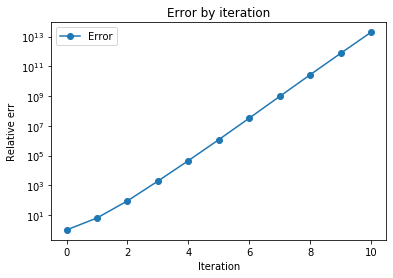

In [53]:
# Fine grid problem
n = 16 # total points in 1D (0,n are the boundary points), choose a power of 2.
N = (n-1)*(n-1)
ep = 0.001
A = ModelProblem2DAnisotropic(n,1,ep)

# RHS, soln, initial
u_final = np.zeros(N)
f = np.dot(A,u_final)
u = np.random.rand(N)
u_init = u.copy()

# Setup the hierarchy
n_fine = n
ratio = 1
num_levels = 1
A_array = [A]
u_array = [u]
f_array = [f]
P_array = []
R_array = []
while n_fine > 8:
    P_array.append( LinearInterpolation2DSemiCoarsening(n_fine) )
    R_array.append( RestrictionFullWeighting2DSemiCoarsening(n_fine) )
    n_fine = int(n_fine/2)
    ratio = ratio * 2
    A_array.append( ModelProblem2DAnisotropic(n_fine,ratio,ep) )
    u_array.append( np.zeros((n_fine*2-1)*(n_fine-1)) )
    f_array.append( np.zeros((n_fine*2-1)*(n_fine-1)) )
    num_levels = num_levels + 1

# Do V-cycles
numIterations = 10
err = np.zeros(numIterations+1)
err[0] = np.linalg.norm(u_final - u)
for it in range(numIterations):
    # Downsweep
    for i in range(num_levels-1):
        GaussSeidel(A_array[i],u_array[i],f_array[i]) # relax
        f_array[i+1] = np.dot( R_array[i] , f_array[i] - np.dot(A_array[i],u_array[i]) ) # residual restriction
        u_array[i+1].fill(0)

    u_array[num_levels-1] = np.linalg.solve(A_array[num_levels-1], f_array[num_levels-1]) # coarse-grid solve

    for i in range(num_levels - 2, -1, -1):
        u_array[i] = u_array[i] + np.dot(P_array[i],u_array[i+1]) # interpolate and add correction
        GaussSeidel(A_array[i],u_array[i],f_array[i]) # relax

    err[it+1] = np.linalg.norm(u_final - u_array[0])

u = u_array[0]

# Plot error by iteration
plt.figure()
plt.title('Error by iteration')
plt.xlabel('Iteration')
plt.ylabel('Relative err')
plt.semilogy(err/err[0],'-o')
plt.legend(['Error'])

# Print convergence factor
CF = np.prod(err[1:len(err)-1]/err[0:len(err)-2])**(1.0/numIterations)
print(N)
print(CF)